# Week 2 Lab: From ImageNet to GeoVision

**Objective:** Explore how pre-trained computer vision models perform on Earth observation imagery to understand domain shift.

**Learning Goals:**
- Load and use pre-trained ImageNet models
- Apply models to satellite imagery from your study region
- Visualize model activations and predictions
- Analyze domain shift and model failures

---

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from pathlib import Path
from PIL import Image

# PyTorch and TorchVision
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import create_feature_extractor

# Earth Engine and geemap
import ee
import geemap

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Initialize Earth Engine
try:
    ee.Initialize()
    print('EE initialized')
except Exception:
    print('EE not initialized; authenticating...')
    ee.Authenticate()
    ee.Initialize()

print("✓ All libraries imported successfully")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Earth Engine initialized")

EE initialized
✓ All libraries imported successfully
  PyTorch version: 2.8.0
  Earth Engine initialized


## Part 1: Load Pre-Trained ImageNet Model

We'll use ResNet-50, a popular CNN architecture trained on ImageNet.

In [2]:
# Load pre-trained ResNet-50 (ImageNet)
print("Loading ResNet-50 (this may take a moment on first run)...")

# Device selection
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use modern weights API
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device).eval()

print("✓ Model loaded successfully")
print(f"  Device: {device}")
print(f"  Model has {sum(p.numel() for p in model.parameters()):,} parameters")

Loading ResNet-50 (this may take a moment on first run)...
✓ Model loaded successfully
  Device: cpu
  Model has 25,557,032 parameters


In [3]:
# ImageNet labels and preprocessing from weights
imagenet_labels = weights.meta.get('categories', None)
preprocess = weights.transforms()

print(f"✓ Loaded {len(imagenet_labels) if imagenet_labels else 'unknown'} ImageNet class labels from weights")

✓ Loaded 1000 ImageNet class labels from weights


## Part 2: Select Your Area of Interest (Interactive)

Draw your AOI on the map. This ensures you precisely define the study region before fetching imagery.

Instructions:
- Use the draw tool to create a Polygon or Rectangle around your AOI.
- Click "Set AOI" to save it to the variable `aoi`.
- Then run the next cell to fetch Sentinel‑2 imagery for your AOI.

In [4]:
# Interactive AOI selection
# How to use:
# 1) Use the map's draw tool (polygon or rectangle) to delineate your AOI.
# 2) Click "Set AOI" to store it in the variable `aoi`.
# 3) Run the next cell to fetch Sentinel-2 imagery.

import ipywidgets as widgets
from ipyleaflet import DrawControl
from IPython.display import display

# Create/clear a working map
AOI_Map = geemap.Map()

# Optional: show a basemap users can orient with
AOI_Map.addLayer(ee.Image().visualize(), {}, 'Basemap')

# Drawing control for polygon/rectangle only
if not any(isinstance(c, DrawControl) for c in AOI_Map.controls):
    dc_aoi = DrawControl(marker={}, polyline={}, circle={}, circlemarker={},
                         polygon={"shapeOptions": {}}, rectangle={"shapeOptions": {}})
    AOI_Map.add_control(dc_aoi)
else:
    dc_aoi = [c for c in AOI_Map.controls if isinstance(c, DrawControl)][0]

_aoi_geom = {'type': None, 'coordinates': None}
status_aoi = widgets.HTML('Draw a Polygon/Rectangle, then click "Set AOI".')
set_btn = widgets.Button(description='Set AOI', button_style='primary')

# Capture last drawn polygon/rectangle

def _on_draw_aoi(target, action, geo_json):
    if action != 'created':
        return
    g = geo_json.get('geometry', {})
    if g.get('type') in ('Polygon', 'Rectangle') or g.get('type') == 'MultiPolygon':
        _aoi_geom['type'] = g['type']
        _aoi_geom['coordinates'] = g['coordinates']
        status_aoi.value = 'AOI geometry captured. Click "Set AOI".'
    else:
        status_aoi.value = '<b>Use Polygon or Rectangle for AOI.</b>'

dc_aoi.on_draw(_on_draw_aoi)

aoi = None

def _set_aoi(_):
    global aoi
    if not _aoi_geom['coordinates']:
        status_aoi.value = '<b>No geometry found.</b> Draw Polygon/Rectangle first.'
        return
    # Build EE geometry (handle both Polygon/Rectangle)
    try:
        if _aoi_geom['type'] == 'Polygon':
            aoi = ee.Geometry.Polygon(_aoi_geom['coordinates'])
        elif _aoi_geom['type'] == 'Rectangle':
            # Rectangle coordinates given as polygon; wrap directly
            aoi = ee.Geometry.Polygon(_aoi_geom['coordinates'])
        elif _aoi_geom['type'] == 'MultiPolygon':
            aoi = ee.Geometry.MultiPolygon(_aoi_geom['coordinates'])
        else:
            raise ValueError('Unsupported geometry type for AOI.')
        status_aoi.value = '✓ AOI set. You can proceed to the next cell.'
        # Outline AOI for feedback
        outline = ee.Image().paint(aoi, 0, 2)
        AOI_Map.addLayer(outline, {'palette': ['cyan']}, 'AOI (selected)')
        AOI_Map.centerObject(aoi, 10)
    except Exception as e:
        status_aoi.value = f'<b>Error setting AOI:</b> {e}'

set_btn.on_click(_set_aoi)

ui = widgets.VBox([AOI_Map, widgets.HBox([set_btn]), status_aoi])
display(ui)
print("When AOI is set, proceed to load Sentinel-2 imagery below.")

When AOI is set, proceed to load Sentinel-2 imagery below.


In [8]:
# Load Sentinel-2 imagery for the selected AOI
assert aoi is not None, "AOI is not set. Draw and 'Set AOI' above first."

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Filter for your region and time period
image = (s2
    .filterBounds(aoi)
    .filterDate('2023-06-01', '2023-09-01')  # Adjust dates as needed
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .median())  # Create median composite

# Select RGB bands
rgb_image = image.select(['B4', 'B3', 'B2'])

print("✓ Sentinel-2 imagery loaded")

✓ Sentinel-2 imagery loaded


## Part 3: Define Sample Locations (Interactive)

You will identify three land-cover categories inside your AOI using the map below. This visual check ensures your samples are within bounds and representative.

Instructions:
- Use the dropdown to choose a class (Forest, Water, Urban, Agriculture).
- Click inside the AOI to add a point. The point is colored by class and validated against the AOI.
- Add at least three points covering at least three distinct classes.
- Click Export when done; this populates `land_cover_samples` for the rest of the notebook.

In [9]:
# Interactive section below defines `land_cover_samples`.
# Use the map and Export button; this placeholder ensures the name exists.
land_cover_samples = {}
print("Awaiting interactive sampling...")

Awaiting interactive sampling...


In [11]:
# Interactive sampling: add labeled points within the AOI
# How to use:
# 1) Pick a class in the Class dropdown (Forest/Water/Urban/Agriculture).
# 2) Click on the map INSIDE the AOI outline to drop a point for that class.
# 3) Repeat for at least three distinct classes.
# 4) Click "Export samples" when done. Then run the next cell to confirm.

import ipywidgets as widgets
from ipyleaflet import DrawControl
from IPython.display import display

# Ensure a sampling map exists (create if missing)
try:
    Map
except NameError:
    Map = geemap.Map()
    try:
        aoi_geom = aoi.geometry()
    except Exception:
        aoi_geom = aoi
    Map.add_basemap('SATELLITE')
    Map.addLayer(rgb_image, {'min': 0, 'max': 3000}, 'S2 RGB (median)')
    outline = ee.Image().paint(aoi_geom, 0, 2)
    Map.addLayer(outline, {'palette': ['00FFFF']}, 'AOI (outline)')
    Map.centerObject(aoi_geom, 12)
    display(Map)

label_dd = widgets.Dropdown(
    options=['Forest', 'Water', 'Urban', 'Agriculture'],
    value='Forest',
    description='Class:'
)
save_btn = widgets.Button(description='Export samples', button_style='primary')
status = widgets.HTML('Pick a Class, click on map to add a point. Then click Export.')

# Add a point-only drawing control (reuse if already added)
if not any(isinstance(c, DrawControl) for c in Map.controls):
    dc = DrawControl(marker={"shapeOptions": {}}, polyline={}, polygon={}, circle={}, rectangle={}, circlemarker={})
    Map.add_control(dc)
else:
    dc = [c for c in Map.controls if isinstance(c, DrawControl)][0]

collected = []

# AOI geometry for validation
try:
    aoi_geom = aoi.geometry()
except Exception:
    aoi_geom = aoi

# Color by class for quick visual feedback
cls_color = {'Forest': 'green', 'Water': 'blue', 'Urban': 'red', 'Agriculture': 'orange'}

def _on_draw(target, action, geo_json):
    if action != 'created' or geo_json.get('geometry', {}).get('type') != 'Point':
        return
    lon, lat = geo_json['geometry']['coordinates']
    label = label_dd.value
    inside = ee.Geometry(aoi_geom).contains(ee.Geometry.Point([lon, lat])).getInfo()
    collected.append({'label': label, 'lon': lon, 'lat': lat, 'inside': inside})
    # Visual marker via EE layer color
    Map.addLayer(ee.Geometry.Point([lon, lat]), {'color': cls_color.get(label, 'yellow')}, f'{label} ({len(collected)})')
    if not inside:
        status.value = f"<b>Warning:</b> Outside AOI: {label} @ ({lon:.5f}, {lat:.5f}). Place inside outline."
    else:
        status.value = f"Added {label} @ ({lon:.5f}, {lat:.5f})"

dc.on_draw(_on_draw)

# Export to a Python dict of ee.Geometry.Point for downstream cells
land_cover_samples = {}

def _export_samples(_):
    global land_cover_samples
    land_cover_samples = {f"{d['label']}_{i}": ee.Geometry.Point([d['lon'], d['lat']]) for i, d in enumerate(collected, 1)}
    outside = [d for d in collected if not d['inside']]
    if outside:
        print(f"⚠ {len(outside)} point(s) outside AOI. Remove or re-add before proceeding.")
    print(f"✓ Collected {len(collected)} point(s). 'land_cover_samples' set.")
    print("Next: run the 'Finalize your samples' cell below to confirm and preview.")

save_btn.on_click(_export_samples)

widgets.VBox([
    widgets.HBox([label_dd, save_btn]),
    status
])


Map(center=[40.679591767317056, -96.64707200000109], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# Sampling map: centered on AOI with true-color context
Map = geemap.Map()

# Ensure we have a geometry for centering and outline
try:
    aoi_geom = aoi.geometry()
except Exception:
    aoi_geom = aoi

# Basemap imagery for context
Map.add_basemap('SATELLITE')

# Convert sample dict to an EE FeatureCollection with labels (may be empty)
features = [ee.Feature(geom, {'label': name}) for name, geom in land_cover_samples.items()]
fc_points = ee.FeatureCollection(features)

# Add layers: Sentinel‑2 RGB + AOI outline + any existing points
Map.addLayer(rgb_image, {'min': 0, 'max': 3000}, 'S2 RGB (median)')
outline = ee.Image().paint(aoi_geom, 0, 2)  # 2 px outline
Map.addLayer(outline, {'palette': ['00FFFF']}, 'AOI (outline)')
if len(features):
    Map.addLayer(fc_points, {'color': 'red'}, 'Sample points')

# Center map tighter for sampling
Map.centerObject(aoi_geom, 12)
Map


Map(center=[40.679591767317056, -96.64707200000109], controls=(WidgetControl(options=['position', 'transparent…

### Finalize your samples

- If you have added points, click Export.
- Then run the cell below to confirm and proceed. You need at least three distinct classes (e.g., Forest, Water, Urban).


In [13]:
# Validate and display collected samples
assert land_cover_samples, "No samples found. Use the map to add points, then click Export."

# Count distinct classes
classes = [k.split('_')[0] for k in land_cover_samples.keys()]
num_classes = len(set(classes))
print(f"Collected {len(land_cover_samples)} point(s) across {num_classes} class(es):")
for name, geom in land_cover_samples.items():
    print("  ", name, geom.coordinates().getInfo())

assert num_classes >= 3, "Collect at least three distinct classes before continuing."

# Build a map preview of the exported samples
Map = geemap.Map()
try:
    aoi_geom = aoi.geometry()
except Exception:
    aoi_geom = aoi

Map.addLayer(rgb_image, {'min': 0, 'max': 3000}, 'S2 RGB (median)')
Map.addLayer(aoi_geom, {'color': '#00FFFF'}, 'AOI')
fc = ee.FeatureCollection([ee.Feature(g, {'label': k}) for k, g in land_cover_samples.items()])
Map.addLayer(fc, {'color': 'yellow'}, 'Exported samples')
Map.centerObject(aoi_geom, 10)
Map


Collected 4 point(s) across 4 class(es):
   Forest_1 [-96.689386, 40.705238]
   Water_2 [-96.640034, 40.715794]
   Urban_3 [-96.617718, 40.717079]
   Agriculture_4 [-96.60038, 40.675691]


Map(center=[40.679591767317056, -96.64707200000109], controls=(WidgetControl(options=['position', 'transparent…

## Part 4: Helper Functions

Functions to download imagery and run inference.

In [14]:
def ee_to_numpy(image, region, scale=10):
    """
    Download Earth Engine image as numpy array.
    
    Args:
        image: Earth Engine image (ee.Image)
        region: Earth Engine geometry (ee.Geometry)
        scale: Spatial resolution in meters (e.g., 10 or 20)
    
    Returns:
        numpy array of shape (H, W, C)
    """
    # Reproject for consistent sampling resolution
    img = image.reproject(crs='EPSG:4326', scale=scale)

    # Sample rectangle
    image_data = img.sampleRectangle(region=region, defaultValue=0)
    
    # Convert to numpy in RGB band order
    bands = ['B4', 'B3', 'B2']  # RGB
    arrays = [np.array(image_data.get(band).getInfo()) for band in bands]
    
    # Stack to (H, W, C)
    rgb_array = np.stack(arrays, axis=-1)
    
    return rgb_array

print("✓ Helper functions defined")

✓ Helper functions defined


In [15]:
# Preprocessing pipeline is provided by weights (see above)

def predict_patch(rgb_array, model, preprocess, imagenet_labels, top_k=5):
    """
    Run ImageNet model inference on a satellite image patch.
    
    Args:
        rgb_array: numpy array of shape (H, W, 3)
        model: PyTorch model
        preprocess: torchvision transforms (from weights)
        imagenet_labels: list of class labels (from weights.meta)
        top_k: number of top predictions to return
    
    Returns:
        list of (label, confidence) tuples, and the normalized RGB array
    """
    # Normalize to 0-255 range
    rgb_norm = (rgb_array - rgb_array.min()) / (rgb_array.max() - rgb_array.min()) * 255
    rgb_norm = rgb_norm.astype(np.uint8)
    
    # Convert to PIL Image
    pil_image = Image.fromarray(rgb_norm)
    
    # Preprocess and move to device
    input_tensor = preprocess(pil_image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        output = model(input_batch)
    
    # Get top-k predictions (move to CPU for numpy-friendly ops)
    probabilities = torch.nn.functional.softmax(output[0].to('cpu'), dim=0)
    top_prob, top_idx = torch.topk(probabilities, top_k)
    
    # Format results
    predictions = []
    for prob, idx in zip(top_prob, top_idx):
        label = imagenet_labels[idx.item()] if imagenet_labels else str(idx.item())
        predictions.append({
            'label': label,
            'confidence': prob.item() * 100
        })
    
    return predictions, rgb_norm

print("✓ Prediction function defined")

✓ Prediction function defined


## Part 5: Run Experiments

Test the ImageNet model on each land cover type.

In [16]:
# Store results
results = {}
patches = {}

# Test each land cover type
for lc_type, point in land_cover_samples.items():
    print(f"\n{'='*60}")
    print(f"Testing: {lc_type}")
    print(f"{'='*60}")
    
    try:
        # Define region (500m buffer)
        region = point.buffer(500)
        
        # Download patch
        print("  Downloading patch...")
        rgb_array = ee_to_numpy(rgb_image, region)
        print(f"  Patch shape: {rgb_array.shape}")
        
        # Run prediction
        print("  Running inference...")
        predictions, rgb_norm = predict_patch(
            rgb_array, model, preprocess, imagenet_labels
        )
        
        # Store results
        results[lc_type] = predictions
        patches[lc_type] = rgb_norm
        
        # Display predictions
        print("\n  Top 5 Predictions:")
        for i, pred in enumerate(predictions, 1):
            print(f"    {i}. {pred['label']:30s} {pred['confidence']:5.2f}%")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        results[lc_type] = None
        patches[lc_type] = None

print(f"\n{'='*60}")
print("Experiments complete!")
print(f"{'='*60}")


Testing: Forest_1
  Patch shape: (101, 132, 3)
  Running inference...

  Top 5 Predictions:
    1. velvet                          2.47%
    2. lacewing                        1.88%
    3. bow                             1.45%
    4. birdhouse                       1.24%
    5. walking stick                   1.21%

Testing: Water_2
  Patch shape: (101, 132, 3)
  Running inference...

  Top 5 Predictions:
    1. airliner                        6.88%
    2. horizontal bar                  1.65%
    3. lakeside                        1.57%
    4. steel arch bridge               1.40%
    5. hog                             1.37%

Testing: Urban_3
  Patch shape: (101, 133, 3)
  Running inference...

  Top 5 Predictions:
    1. velvet                         20.46%
    2. prayer rug                     11.65%
    3. maze                            5.23%
    4. spider web                      1.89%
    5. bath towel                      0.98%

Testing: Agriculture_4
  Patch shape: (101, 133

## Part 6: Visualize Results

Create a multi-panel figure showing patches and predictions.

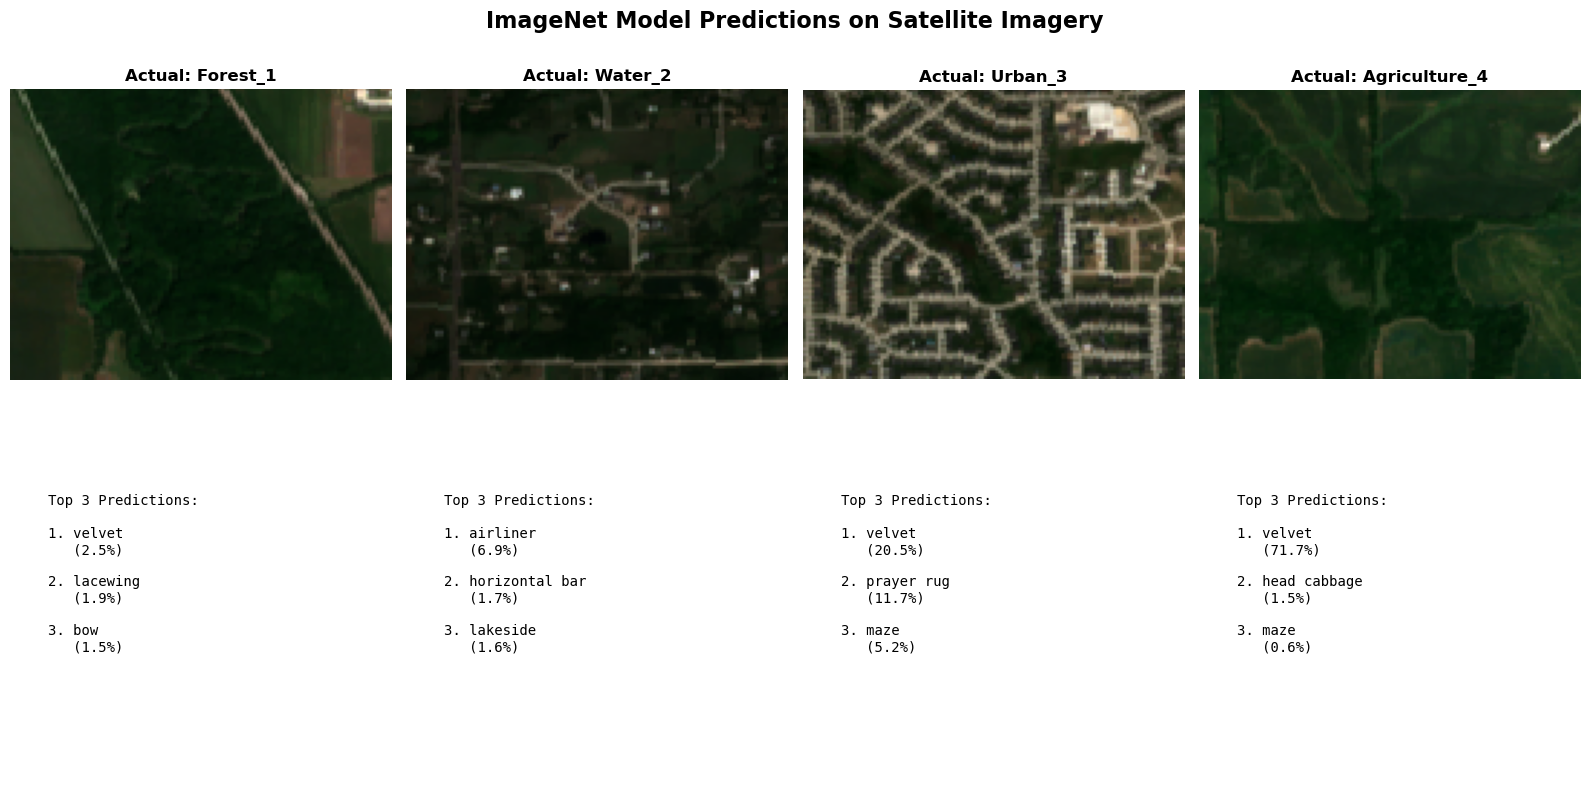

✓ Visualization saved to ../figures/week2_imagenet_predictions.png


In [17]:
# Create visualization
n_samples = len([p for p in patches.values() if p is not None])
fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))

col = 0
for lc_type in land_cover_samples.keys():
    if patches[lc_type] is None:
        continue
    
    # Top row: satellite image
    axes[0, col].imshow(patches[lc_type])
    axes[0, col].set_title(f'Actual: {lc_type}', fontweight='bold', fontsize=12)
    axes[0, col].axis('off')
    
    # Bottom row: predictions
    axes[1, col].axis('off')
    
    # Format predictions as text
    pred_text = "Top 3 Predictions:\n\n"
    for i, pred in enumerate(results[lc_type][:3], 1):
        pred_text += f"{i}. {pred['label']}\n"
        pred_text += f"   ({pred['confidence']:.1f}%)\n\n"
    
    axes[1, col].text(0.1, 0.5, pred_text, 
                     fontsize=10, verticalalignment='center',
                     family='monospace')
    
    col += 1

plt.suptitle('ImageNet Model Predictions on Satellite Imagery', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../figures/week2_imagenet_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to ../figures/week2_imagenet_predictions.png")

## Part 7: Activation Visualization

Visualize what the model is "looking at" using feature maps.

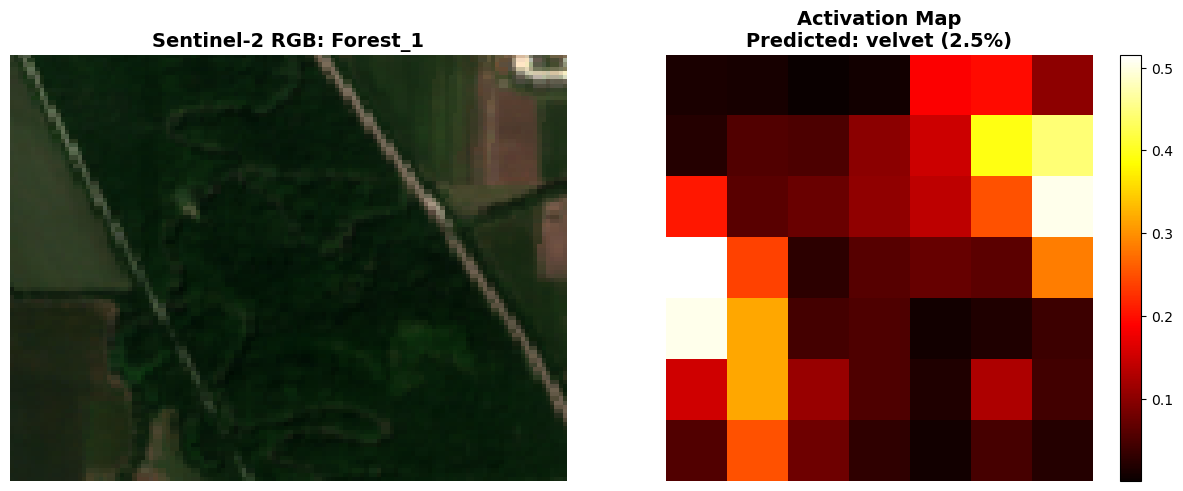

✓ Activation map saved for Forest_1


In [19]:
# Select one example for detailed activation analysis (auto-pick)
# Prefer any key starting with "Forest" (e.g., "Forest_1"); otherwise use the first available patch.
preferred = 'Forest'
available = [k for k, v in patches.items() if v is not None]
if not available:
    print("✗ No patches available. Run Part 5 first.")
else:
    candidates = [k for k in available if k.lower().startswith(preferred.lower())]
    example_key = candidates[0] if candidates else available[0]

    # Get the patch
    rgb_array = patches[example_key]
    
    # Preprocess
    rgb_norm = (rgb_array - rgb_array.min()) / (rgb_array.max() - rgb_array.min()) * 255
    rgb_norm = rgb_norm.astype(np.uint8)
    pil_image = Image.fromarray(rgb_norm)
    input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
    
    # Create feature extractor
    feature_extractor = create_feature_extractor(
        model, 
        return_nodes={'layer4': 'features'}
    )
    
    # Extract features
    with torch.no_grad():
        features = feature_extractor(input_tensor)['features']
    
    # Average across channels (move to CPU)
    activation_map = features[0].to('cpu').mean(dim=0).numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    axes[0].imshow(rgb_array)
    axes[0].set_title(f'Sentinel-2 RGB: {example_key}', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Activation map
    im = axes[1].imshow(activation_map, cmap='hot')
    top_pred = results[example_key][0]
    axes[1].set_title(f'Activation Map\nPredicted: {top_pred["label"]} ({top_pred["confidence"]:.1f}%)',
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    plt.tight_layout()
    plt.savefig(f'../figures/week2_activation_{example_key.lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Activation map saved for {example_key}")

## Part 8: Analysis and Reflection

Answer these questions based on your experiments:

### Observations

1. **Which land cover types were most misclassified?**

   *Your answer here*

2. **What patterns do you notice in the misclassifications?**

   *Your answer here*

3. **How do the activation maps relate to the predictions?**

   *Your answer here*

### Explanations

4. **Why do you think the model made these specific errors?**

   *Your answer here (consider scale, spectral information, training data)*

5. **How does this demonstrate the domain shift problem?**

   *Your answer here*

### Implications

6. **What would you need to do to make this model work better for Earth observation?**

   *Your answer here*

7. **What does this tell you about the importance of domain-specific training?**

   *Your answer here*

## Part 9: Summary Statistics

Create a summary table of results.

In [20]:
import pandas as pd

# Create summary table
summary_data = []
for lc_type, preds in results.items():
    if preds is not None:
        top_pred = preds[0]
        summary_data.append({
            'Actual Land Cover': lc_type,
            'Top Prediction': top_pred['label'],
            'Confidence (%)': f"{top_pred['confidence']:.1f}",
            'Correct?': 'No' if lc_type.lower() not in top_pred['label'].lower() else 'Maybe'
        })

summary_df = pd.DataFrame(summary_data)
print("\nSummary of ImageNet Predictions on Satellite Imagery:")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Save to file
summary_df.to_csv('../reports/week2_prediction_summary.csv', index=False)
print("\n✓ Summary saved to ../reports/week2_prediction_summary.csv")


Summary of ImageNet Predictions on Satellite Imagery:
Actual Land Cover Top Prediction Confidence (%) Correct?
         Forest_1         velvet            2.5       No
          Water_2       airliner            6.9       No
          Urban_3         velvet           20.5       No
    Agriculture_4         velvet           71.7       No

✓ Summary saved to ../reports/week2_prediction_summary.csv


## Conclusion

This experiment demonstrates the **domain shift problem**: models trained on natural images (ImageNet) often fail when applied to satellite imagery because:

1. **Scale mismatch**: Satellite features are at different scales than everyday objects
2. **Spectral vs. visual**: Models learn visual appearance, not spectral signatures
3. **Context matters**: Geographic and environmental context is crucial for Earth observation
4. **Training distribution**: ImageNet contains photos, not satellite imagery

**Next steps:**
- Week 3: Train CNNs specifically for Earth observation data
- Weeks 4-6: Explore transfer learning and domain adaptation
- Weeks 7-10: Use foundation models trained on satellite imagery

---

**Deliverables for this lab:**
- ✅ This completed notebook
- ✅ Prediction visualization: `figures/week2_imagenet_predictions.png`
- ✅ Activation maps: `figures/week2_activation_*.png`
- ✅ Summary table: `reports/week2_prediction_summary.csv`
- ✅ Domain shift analysis: `reports/Week2_Domain_Shift_Analysis.md` (separate document)
- ✅ Ethics Thread post: `reports/Week2_Ethics_Thread.md` (separate document)